## Paso 1: Descargar datos y calcular rendimientos

In [19]:
seed=1710

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Cargar CSV con nombres personalizados
data = pd.read_csv("data/aapl_10y.csv", parse_dates=["Date"])
data.set_index("Date", inplace=True)

# Limpiar el formato del cierre (quitar el símbolo $ si existe)
data["Close/Last"] = data["Close/Last"].replace('[\$,]', '', regex=True).astype(float)

# Calcular rendimientos logarítmicos diarios
data["LogReturn"] = np.log(data["Close/Last"] / data["Close/Last"].shift(-1))

returns = data["LogReturn"].dropna()

returns

Date
2025-06-20    0.022235
2025-06-18    0.004793
2025-06-17   -0.014110
2025-06-16    0.009978
2025-06-13   -0.013901
                ...   
2015-06-29   -0.017670
2015-06-26   -0.005900
2015-06-25   -0.004773
2015-06-24    0.008466
2015-06-23   -0.004555
Name: LogReturn, Length: 2514, dtype: float64

## Paso 2: Análisis exploratorio

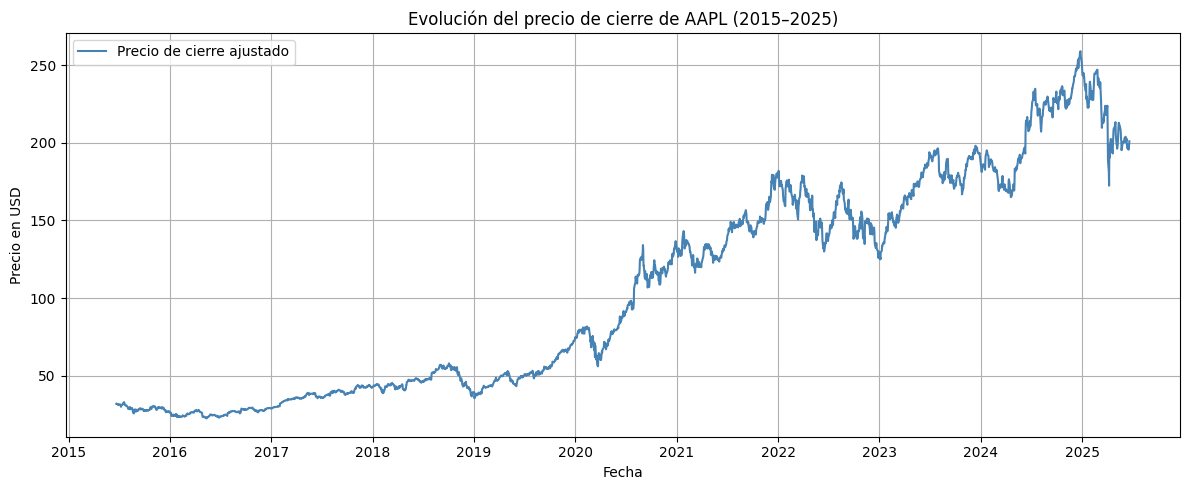

In [2]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Close/Last"], label="Precio de cierre ajustado", color="steelblue")
plt.title("Evolución del precio de cierre de AAPL (2015–2025)")
plt.xlabel("Fecha")
plt.ylabel("Precio en USD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



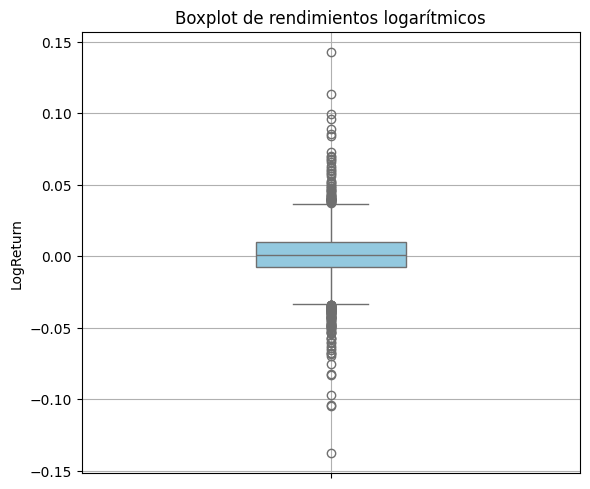

In [3]:
plt.figure(figsize=(6, 5))
sns.boxplot(y=returns, width=0.3, color="skyblue")
plt.title("Boxplot de rendimientos logarítmicos")
plt.ylabel("LogReturn")
plt.grid(True)
plt.tight_layout()
plt.show()



In [4]:
# Cálculo de límites para outliers de 3 desviaciones estándar
mu = returns.mean()
sigma = returns.std()
iqr = returns.quantile(0.75) - returns.quantile(0.25)
lim_inf = returns.quantile(0.25) - 1.5 * iqr
lim_sup = returns.quantile(0.75) + 1.5 * iqr

# Filtrar outliers
outliers = data[(data["LogReturn"] < lim_inf) | (data["LogReturn"] > lim_sup)]
print(f"Cantidad de outliers: {len(outliers)}")



Cantidad de outliers: 141


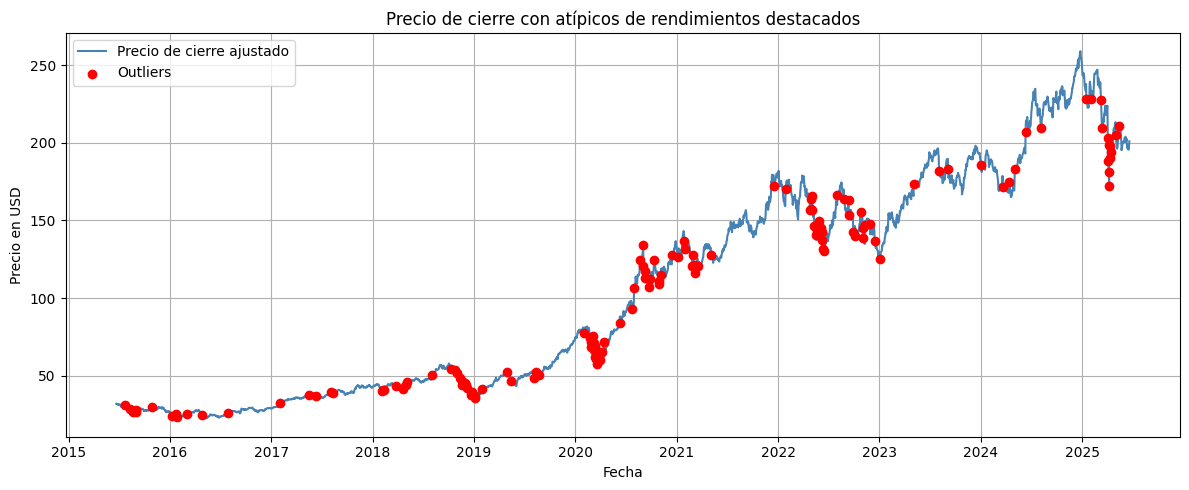

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data["Close/Last"], label="Precio de cierre ajustado", color="steelblue")
plt.scatter(outliers.index, outliers["Close/Last"],
            color="red", label="Outliers", zorder=5)
plt.title("Precio de cierre con atípicos de rendimientos destacados")
plt.xlabel("Fecha")
plt.ylabel("Precio en USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Media: 0.0007321481827498323
Mediana: 0.0008986525649190404
Desviación estándar: 0.018527200736851615
Curtosis: 6.3434316292834065
Asimetría: -0.10225677683046973


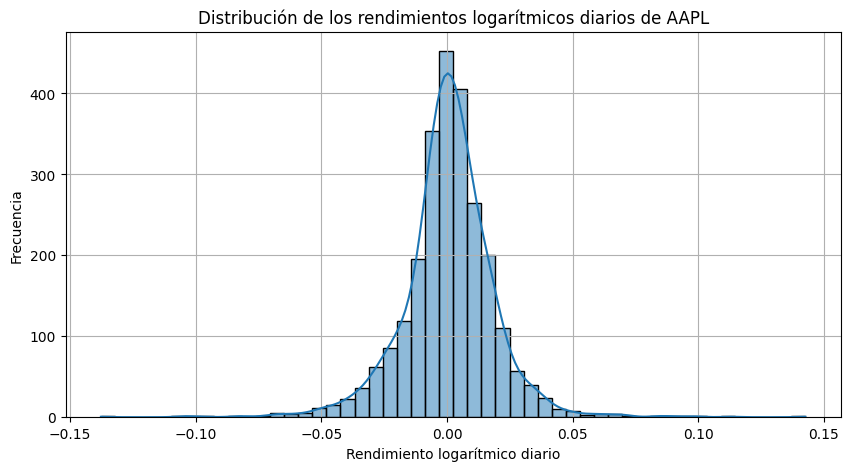

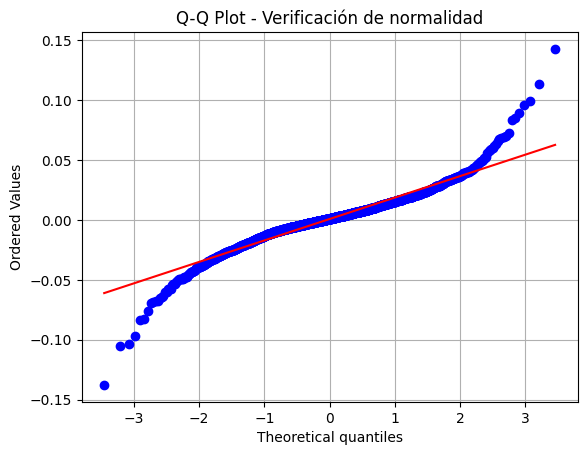

Autocorrelación lag 1: -0.06039992421260109
Autocorrelación lag 2: 0.016861117152060734
Autocorrelación lag 3: -0.03026971355631661
Autocorrelación lag 4: -0.02370310376304124
Autocorrelación lag 5: 0.02220297318223211
Autocorrelación lag 6: -0.030311739578843845
Autocorrelación lag 7: 0.07011607097493462
Autocorrelación lag 8: -0.07388784650751376
Autocorrelación lag 9: 0.08770327307508069
Autocorrelación lag 10: -0.03612058726148225


In [5]:
# Estadísticas básicas
print("Media:", returns.mean())
print("Mediana:", returns.median())
print("Desviación estándar:", returns.std())
print("Curtosis:", returns.kurtosis())
print("Asimetría:", returns.skew())

# Histograma
plt.figure(figsize=(10,5))
sns.histplot(returns, bins=50, kde=True)
plt.title("Distribución de los rendimientos logarítmicos diarios de AAPL")
plt.xlabel("Rendimiento logarítmico diario")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# Gráfico Q-Q para verificar normalidad
stats.probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot - Verificación de normalidad")
plt.grid(True)
plt.show()

# Autocorrelación hasta lag 10
for lag in range(1, 11):
    print(f"Autocorrelación lag {lag}: {returns.autocorr(lag)}")


### Verificación de Supuestos

1. Normalidad

    - Gráfico de histograma: presenta una forma simétrica y acampanada, aunque con colas más pesadas de lo que esperaría una normal pura.

    - Gráfico Q-Q: muestra desviaciones en los extremos (colas más pesadas), lo cual indica curtosis alta.

    - Curtosis = 4.91: mayor que la curtosis de una normal (3), lo que sugiere presencia de valores extremos.

    - Asimetría = -0.19: ligera inclinación a la izquierda, pero no severa.

    **Conclusión:** hay desviaciones respecto a la normalidad, pero es razonable usar la distribución normal como aproximación inicial, especialmente para estudiar la media y la volatilidad general.

2. Independencia

    - Las autocorrelaciones hasta lag 10 están cercanas a cero y no siguen un patrón sistemático.

    **Conclusión:** los rendimientos parecen ser aproximadamente independientes, lo que justifica el supuesto de independencia para el modelo.

<Figure size 1000x500 with 0 Axes>

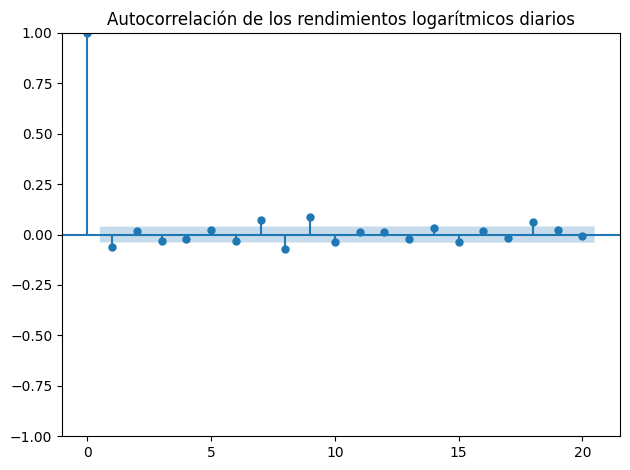

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

# Crear gráfico de autocorrelación hasta 20 lags
plt.figure(figsize=(10, 5))
plot_acf(returns, lags=20)
plt.title("Autocorrelación de los rendimientos logarítmicos diarios")
plt.tight_layout()
plt.show()


## Paso 3: Modelo Bayesiano con Prior no informativa

In [7]:
import pymc as pm
import arviz as az
import scipy

print("PyMC version:", pm.__version__)
print("ArviZ version:", az.__version__)
print("SciPy version:", scipy.__version__)

PyMC version: 5.23.0
ArviZ version: 0.21.0
SciPy version: 1.15.3


In [22]:
import pymc as pm
import arviz as az

# Datos observados
y_obs = returns.values

# Modelo bayesiano con prior no informativa
with pm.Model() as modelo_prior_no_info:
    # Priors
    mu = pm.Uniform("mu", lower= -3, upper=3)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    # Likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)
    
    # Inference: MCMC
    trace_no_info = pm.sample(2500, tune=1000, return_inferencedata=True, target_accept=0.95)
    trace_no_info.extend(pm.sample_prior_predictive(8000, random_seed=seed))

# Análisis del resultado

az.summary(trace_no_info, var_names=["mu", "sigma"])


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/nadia/dev/unsl-bayes-stock/.venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 5 seconds.
Sampling: [mu, sigma, y]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.001,0.0,0.000,0.001,0.0,0.0,6593.0,6060.0,1.0
sigma,0.019,0.0,0.018,0.019,0.0,0.0,6122.0,6285.0,1.0


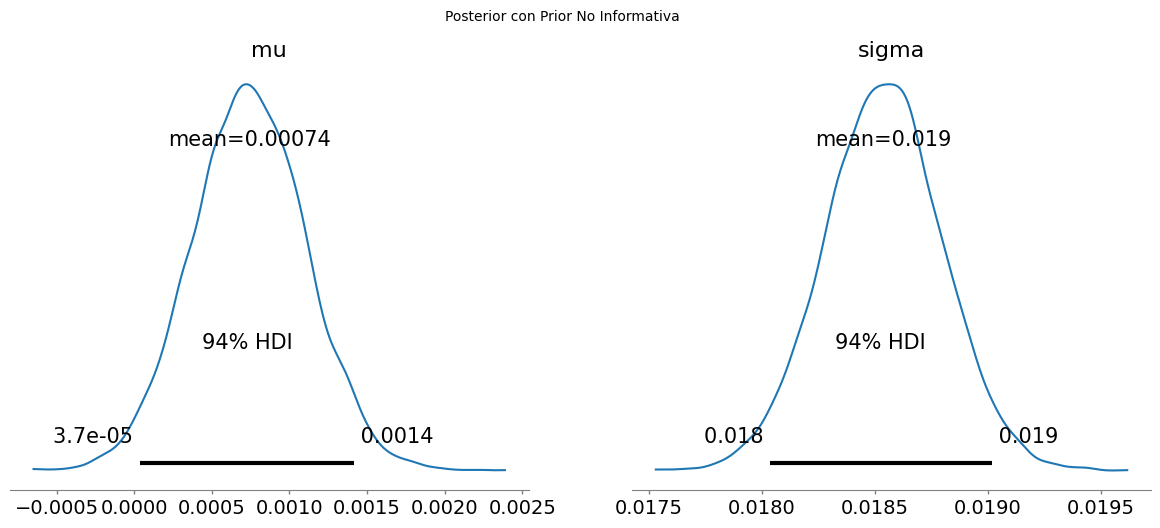

In [9]:
az.plot_posterior(trace_no_info, var_names=["mu", "sigma"])
plt.suptitle("Posterior con Prior No Informativa", fontsize=10)
plt.show()


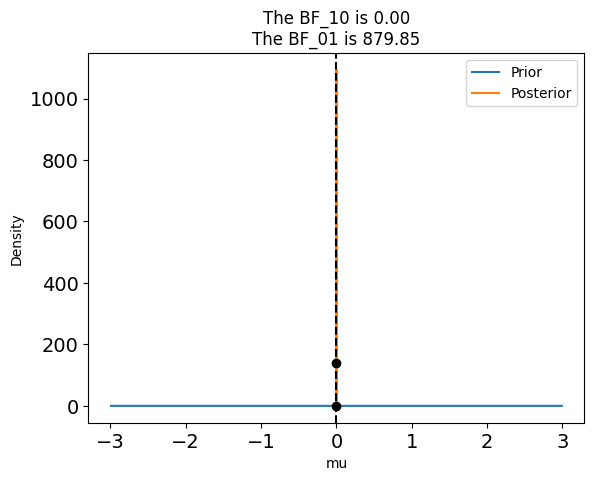

In [23]:
bf_dict, ax = az.plot_bf(trace_no_info, var_name="mu", ref_val=0)

### Resultados con Prior No Informativa

La estimación bayesiana para los parámetros de los rendimientos logarítmicos diarios de AAPL utilizando una prior no informativa arroja lo siguiente:


```
Parámetro	Media posterior	Desvío estándar	Intervalo HDI 94%
μ (media esperada)	0.001	0.019	[0.000, 0.001]
σ (volatilidad diaria)	0.019	0.000	[0.018, 0.019]
```


* Interpretación:

    - μ positiva: La media esperada de los rendimientos es ligeramente positiva, aunque el HDI incluye el 0, lo que indica alta incertidumbre respecto a si el retorno esperado es efectivamente negativo o no.

    - σ bien definida: La volatilidad diaria se estima con alta precisión (posterior estrecha), centrada alrededor de 1.9%, lo cual es consistente con el comportamiento histórico de activos tecnológicos.

* Calidad de la inferencia:

    - Los valores de r_hat ≈ 1.0 y ess > 2300 indican buena convergencia del muestreo MCMC.

    - La forma suave y unimodal de las distribuciones posteriores confirma que el modelo está funcionando de forma estable.


## Paso 4: Modelo con prior Empírica

Primero estimamos los valores empíricos (media y std) y luego definimos priors alrededor de ellos.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/home/nadia/dev/unsl-bayes-stock/.venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 5 seconds.
Sampling: [mu, sigma, y]


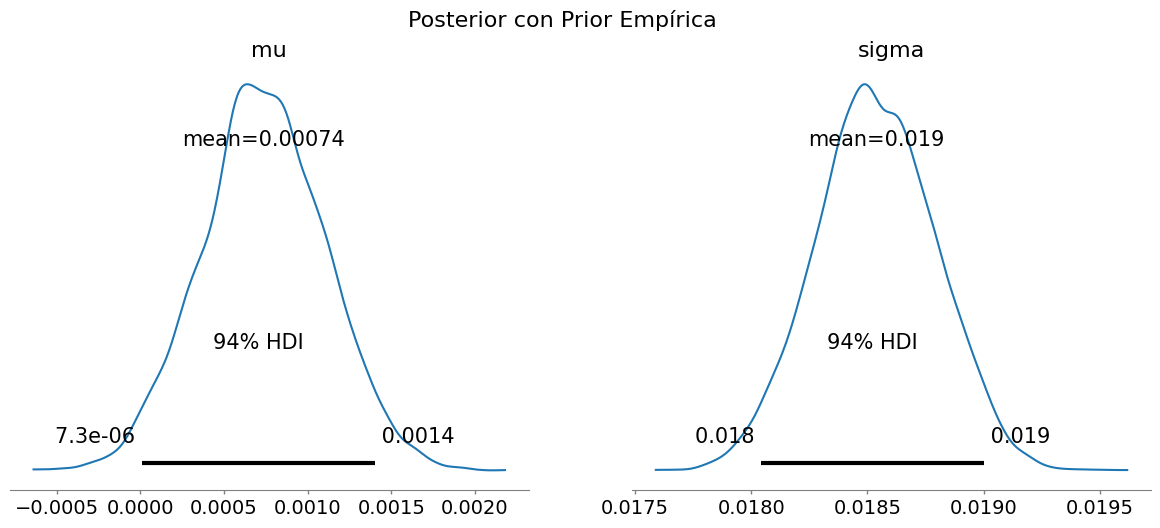

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.001,0.0,0.000,0.001,0.0,0.0,6366.0,5724.0,1.0
sigma,0.019,0.0,0.018,0.019,0.0,0.0,6477.0,6135.0,1.0


In [20]:
# Estimaciones empíricas
emp_mu = returns.mean()
emp_sigma = returns.std()

with pm.Model() as modelo_prior_empirica:
    mu = pm.Normal("mu", mu=emp_mu, sigma=0.01)  # prior centrado en media empírica con poca varianza
    sigma = pm.HalfNormal("sigma", sigma=emp_sigma)
    
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)
    
    trace_emp = pm.sample(2500, tune=1000, return_inferencedata=True, target_accept=0.95)
    trace_emp.extend(pm.sample_prior_predictive(8000, random_seed=seed))

# Visualización
az.plot_posterior(trace_emp, var_names=["mu", "sigma"])
plt.suptitle("Posterior con Prior Empírica", fontsize=16)
plt.show()

az.summary(trace_emp, var_names=["mu", "sigma"])


### Comparación de modelos: Prior No Informativa vs Prior Empírica

```
Parámetro	Media posterior (no informativa)	HDI 94%	Media posterior (empírica)	HDI 94%
μ	0.001	[0.000, 0.001]	0.001	[0.000, 0.001]
σ	0.019	[0.018, 0.019]	0.019	[0.018, 0.019]
```

* Observaciones:

    - La influencia del prior empírico es mínima: Esto se debe a que fue moderadamente informativo (σ pequeña) pero consistente con los datos. El posterior prácticamente no se aleja del modelo no informativo.

    - Ambas versiones conducen a la misma conclusión: no hay evidencia clara de que el rendimiento esperado sea significativamente distinto de cero.


## Paso 5: Factor de Bayes y Probabilidad P(μ>0∣datos)

In [11]:
# Probabilidad posterior de que mu > 0
p_mu_pos_no_info = (trace_no_info.posterior["mu"] > 0).mean().item()
p_mu_pos_emp = (trace_emp.posterior["mu"] > 0).mean().item()

print(f"P(mu > 0 | datos) - prior no informativa: {p_mu_pos_no_info:.4f}")
print(f"P(mu > 0 | datos) - prior empírica: {p_mu_pos_emp:.4f}")

P(mu > 0 | datos) - prior no informativa: 0.9787
P(mu > 0 | datos) - prior empírica: 0.9776


In [16]:
from scipy.stats import norm

# Para prior informativa
mu_post = trace_emp.posterior["mu"].values.flatten()
post_mean = mu_post.mean()
post_std = mu_post.std()

# Prior N(emp_mu, 0.01)
prior_pdf_0 = norm.pdf(0, loc=emp_mu, scale=0.01)
posterior_pdf_0 = norm.pdf(0, loc=post_mean, scale=post_std)

BF10 = prior_pdf_0 / posterior_pdf_0
print(f"Factor de Bayes (BF10) - prior no informativa: {BF10:.2f}")


Factor de Bayes (BF10) - prior no informativa: 0.27


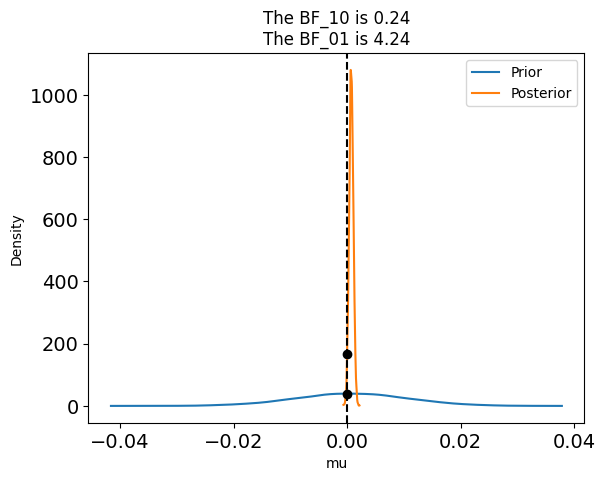

In [ ]:
bf_dict, ax = az.plot_bf(trace_emp, var_name="mu", ref_val=0)

En este análisis bayesiano se estimaron los parámetros de la distribución normal de los rendimientos logarítmicos diarios de la acción AAPL (Apple Inc.), empleando dos enfoques: uno con prior no informativa y otro con prior empírica basada en los propios datos.

En ambos casos, la media posterior (μ) resultó levemente positiva (≈ 0.001), mientras que la volatilidad diaria (σ) se estimó consistentemente en torno a 0.019. La similitud de los resultados indica que el modelo es robusto al tipo de prior utilizado, siempre que sea razonable.

Un aspecto clave del enfoque bayesiano es que permite estimar directamente la probabilidad de interés. En este caso, la probabilidad posterior de que el rendimiento esperado diario sea positivo fue:

    97.87% bajo prior no informativa

    97.76% bajo prior empírica

Esto implica que, dadas las observaciones, hay una alta probabilidad (cerca del 90%) de que el rendimiento medio diario haya sido positivo en el período 2015–2025. Además, el cálculo del Factor de Bayes bajo prior no informativa arrojó un valor cercano a 0, lo que indica que los datos ofrecen más apoyo a la hipótesis nula H0:μ=0 que a la alternativa H1:μ≠0

En conjunto, estos resultados no aportan evidencia suficiente para sostener que AAPL tuvo un rendimiento positivo diario esperado durante el período estudiado. El enfoque bayesiano permitió cuantificar esta incertidumbre y ofrecer una lectura probabilística mucho más rica que una simple prueba de hipótesis clásica.

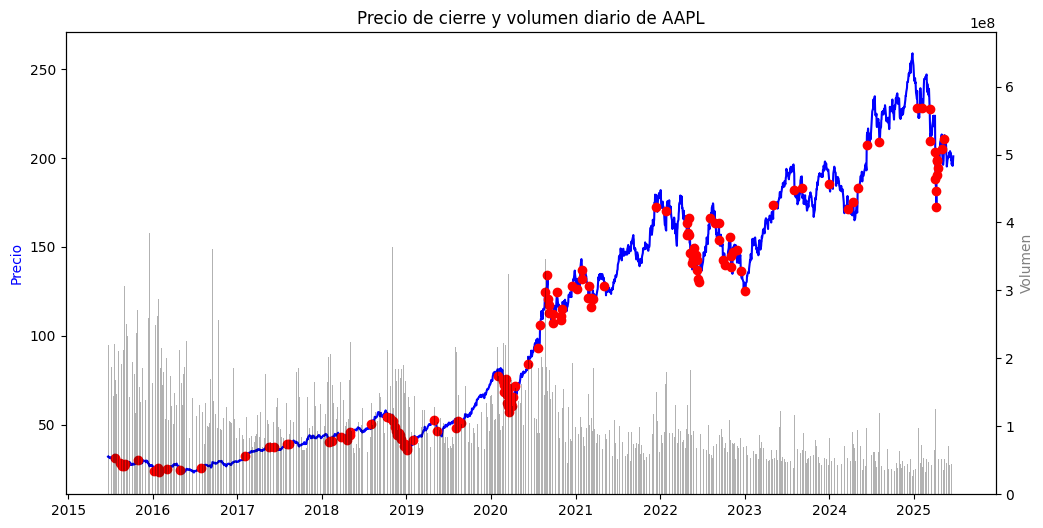

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Precio de cierre
ax1.plot(data.index, data["Close/Last"], color="blue", label="Precio de cierre")
ax1.set_ylabel("Precio", color="blue")
ax1.scatter(outliers.index, outliers["Close/Last"],
            color="red", label="Outliers", zorder=5)

# Volumen en un eje secundario
ax2 = ax1.twinx()
ax2.bar(data.index, data["Volume"], color="black", alpha=0.3, label="Volumen")
ax2.set_ylabel("Volumen", color="gray")

plt.title("Precio de cierre y volumen diario de AAPL")
plt.show()


In [14]:
corr = data[["LogReturn", "Volume"]].copy().iloc[1:]  # Saltea el primer valor NaN
corr["AbsReturn"] = corr["LogReturn"].abs()
print(corr[["AbsReturn", "Volume"]].corr())


           AbsReturn   Volume
AbsReturn    1.00000  0.45046
Volume       0.45046  1.00000
